# Used Hardware

**CPU :  AMD Ryzen 9 3950X 16 Cores /32 threads @ 3.3GHZ.**

**RAM : 2x32GB DDR4 @ 2667 MHz in dual channel mode.**

**All reported run times (especially HyperParameter tuning) are based on this HW configuration.**

# Installed packages and their versions (usefull for Docker )

In [1]:
! pip list

Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
alembic                            1.7.4
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopage                           0.4.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
b

In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import os
import warnings
import datetime
import time
import math
import operator
import random
import gc
import numpy as np
print ('numpy', np.__version__)
import pandas as pd
print ('pandas', pd.__version__)
import pandasql as ps

from dateutil import relativedelta

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import gridspec

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  train_test_split
from ipywidgets import FloatProgress

import json
print('json', json.__version__)
import warnings
import qgrid
import pickle
print ('pickle', pickle.format_version)
import shap as shap

import lightgbm as lgb
print ('lightgbm', lgb.__version__)

import optuna as optuna
print('optuna', optuna.__version__)  
import optuna.integration.lightgbm as lgbm_integration


C:\Users\kyazi\anaconda3\python.exe
3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
numpy 1.20.1
pandas 1.2.4
json 2.0.9
pickle 4.0
lightgbm 3.2.1
optuna 2.10.0


# Define paths 

**The below assumes that this Jupyter notebook is opened directly from the "JupuyterNotebooks" directory**

**Besides this directory, there are three other directories "Data", "Objects" and "Reults"**

**All these four directories should be same-level directories under a common root directory**

**The location of the root directory itself is not important**

In [3]:
root_directory = os.path.dirname(os.getcwd())
PATH_DATA = root_directory + '\\Data\\'
PATH_OBJECTS = root_directory + '\\Objects\\'
PATH_RESULTS = root_directory + '\\Results\\'

# Load Data #

In [4]:
MISSING_VALUES = ['-','.']
DATES = []
_unicode = {}
dataset = 'cashcard_sample2'
data = pd.read_csv(PATH_DATA + dataset + ".csv", encoding = 'utf-8', na_values = MISSING_VALUES, thousands = ',', sep = ',' 
                  ,  dayfirst = True, parse_dates = DATES,  dtype= _unicode )

#mask = data['CA_F_CASH_CARD_TG_CG'] == 'CG'
#data = data[mask]
#data = data.reset_index(drop = True)


def target_code(row):
    c = 0  # corresponds to 'no response'
    if row['FLAG_CLX_SIGNED_30D'] == 1:
        c = 1
    if row['CC_F_USE_30D'] == 1:
        c = 2
    return c


def To_Date(dt, dtime_input_format):
    
    if pd.isnull(dt):
        return np.datetime64('NaT')  #! it is key to have this and not np.NaN
    else: 
        dt = dt[:10]   
        dt = datetime.datetime.strptime( dt, dtime_input_format )
        if dt.year > 2021:  # <--in implementation, replace with datetime.date.today().year
            dt = dt.replace( year=dt.year-100 )
        return dt
    
        
data['target'] = data.apply(lambda row: target_code(row), axis =1)   
data['omni'] = 1
data['WT'] = 1

data['REPORT_DATE'] = data['REPORT_DATE'].apply(lambda x : To_Date(x, '%d/%m/%Y'))
data['month'] = data['REPORT_DATE'].dt.month

display(data.shape)
display(data['target'].value_counts())

(2596307, 205)

0    2589360
1       5072
2       1875
Name: target, dtype: int64

## Meta Data

In [5]:
col_target  = 'target'
col_month = 'month'
col_campaign = 'CA_TYPE'
col_weight = 'WT'

## Split predictors into numeric and categorical

In [6]:
technical =   ['ID_CUID','RUN_DATE','CA_START_DT','REPORT_DATE','CA_F_CASH_CARD_TG_CG','APL_F_SIGN']
technical +=  [col_target,  col_month, col_weight, 'omni'] + ['CC_F_USE_30D', 'FLAG_CLX_SIGNED_30D' ] + ['CA_TYPE']
technical += ['SOC_LAST_APL']

predictors  = [col for col in data.columns if col not in technical]
predictors = sorted(predictors)

column_types = list(zip(data[predictors].columns,data[predictors].dtypes))

cols_pred_cat = [col_name for col_name,dtype in column_types if dtype.name == 'category'\
                 or dtype.name == 'object' or dtype.name == 'bool']

cols_pred_num = [col_name for col_name,dtype in column_types if ('float' in dtype.name) or ('int' in dtype.name)]

cheksum = len(predictors) - len(cols_pred_cat) - len(cols_pred_num)

if cheksum != 0:
    raise ValueError("categorical and numerical predictors do not add up to total number of predictor columns")

print('# predictors :', len(predictors))
print('# numerical predictors :', len(cols_pred_num))
print('# categorical predictors :', len(cols_pred_cat))

# predictors : 191
# numerical predictors : 175
# categorical predictors : 16


## Remove categorical predictors with high cardinality

**High cardinality categorical features can mess up the tree growth as each such feature will have a higher propbabilty for being selected for a spurious split simply due to sheer number of its level, thus creating trees that too-dependent on such unstable featurees.** 

**Another option will be to target-encode each of these predictors, x, by using a simple, cross-validated tree model to create a robust x_SCORE version of x. This will however require more complex implementation since we will have to store, load and implement a separate model for each such variable.**

**Moreover, it will require to reserve a chunck of data for this, reducing the amount of train data available for subsequent modelling and since the number of target classes 1 (Cash) and 2 (Card) is small already, this will not be feasible here**


In [7]:
descrip_cat = data[cols_pred_cat].describe(include='all').transpose()
mask = descrip_cat['unique'] > 20
remove_cat = list(descrip_cat[mask].index)

cols_pred_cat = [pred for pred in cols_pred_cat if pred not in remove_cat]

predictors = cols_pred_num + cols_pred_cat
predictors = sorted(predictors)

print('removed due to high cardinality level :', remove_cat)
print('# predictors :', len(predictors))
print('# numerical predictors :', len(cols_pred_num))
print('# categorical predictors :', len(cols_pred_cat))

removed due to high cardinality level : ['CA_OFFER_TYPE_CODE', 'CA_PROD_PRI_GR', 'SOC_CLI_CONTACT_REGION']
# predictors : 188
# numerical predictors : 175
# categorical predictors : 13


## Remove predictors with low fill rate

In [8]:
_threshould = 0.95

f = FloatProgress(description='Progress:', min = 0, max =len(predictors))
display(f)

MIS = {}
for col in predictors:
    m = 1.0*data.loc[pd.isnull(data[col])].shape[0]/data.shape[0]
    MIS[col] = m
    f.value += 1 
    
sort = sorted(MIS.items(), key = lambda x : x[1], reverse = True)

FILLRATES = pd.DataFrame(sort)
FILLRATES.rename(columns = {0 :'variable', 1:'missing_rate'}, inplace = True)

mask = FILLRATES['missing_rate'] >= _threshould
dropped_variables = list(FILLRATES[mask]['variable'])

cols_pred_num = list(set(cols_pred_num).intersection(set(predictors)) - set(dropped_variables))
cols_pred_cat = list(set(cols_pred_cat).intersection(set(predictors)) - set(dropped_variables))

predictors = cols_pred_num + cols_pred_cat
predictors = sorted(predictors)

print('# removed due to low fill rate :', len(dropped_variables))
print('# predictors :', len(predictors))
print('# numerical predictors :', len(cols_pred_num))
print('# categorical predictors :', len(cols_pred_cat))

FloatProgress(value=0.0, description='Progress:', max=188.0)

# removed due to low fill rate : 42
# predictors : 146
# numerical predictors : 133
# categorical predictors : 13


## Remove constant or almost constant predictors

In [9]:
_threshould = 0.95

#[]
S =  cols_pred_num

f = FloatProgress(description='Progress:', min = 0, max =len(S))
display(f)

drop_list_num = []
for col in S:
    mask = (data[col] == data[col].mode()[0] )
    hommogenity = data[mask].shape[0]/ data.loc[pd.notnull(data[col])].shape[0]
    if hommogenity >= _threshould:
        drop_list_num.append(col)  # more than _threshould%  of cases is just one value
    f.value += 1 

#[]    
S =  cols_pred_cat

f = FloatProgress(description='Progress:', min = 0, max =len(S))
display(f)

drop_list_cat = []
for col in S:
    hommogenity =data[col].value_counts().values.max()/data[col].value_counts().values.sum()
    if hommogenity >= _threshould:
        drop_list_cat.append(col) # more than _threshould%  of cases is just one value   
    f.value += 1
        
cols_pred_num = list(set(cols_pred_num).intersection(set(predictors)) - set(drop_list_num))
cols_pred_cat = list(set(cols_pred_cat).intersection(set(predictors)) - set(drop_list_cat))

predictors = cols_pred_num + cols_pred_cat
predictors = sorted(predictors)

print('# removed predictors due to low variability :', len(drop_list_num) + len(drop_list_cat))
print('# predictors :', len(predictors))
print('# numerical predictors :', len(cols_pred_num))
print('# categorical predictors :', len(cols_pred_cat))

FloatProgress(value=0.0, description='Progress:', max=133.0)

FloatProgress(value=0.0, description='Progress:', max=13.0)

# removed predictors due to low variability : 27
# predictors : 119
# numerical predictors : 106
# categorical predictors : 13


## Save predictors

In [10]:
with open(PATH_OBJECTS + "predictors_CCX", "wb") as f:
            pickle.dump(predictors, f) 

with open(PATH_OBJECTS + "predictors_CLX", "wb") as f:
            pickle.dump(predictors, f) 

## convert 'object' type to 'category' type (necessary for LGBM)

In [11]:
for col in cols_pred_cat:
    data[col] = data[col].astype('category')

# Model training 

In [12]:
default_params = {
        'objective':'multiclass',
        'metric':'multi_logloss',
        'num_class' : 3,
        'early_stopping_rounds':100,
        'num_iterations':10000,
        'max_bin':20,
        'seed':1234,
        'verbose':-1,
        'n_jobs':-1,
}

**Wrapper arround native LGBM cross valiadtion routine. The wrapper returns the best model after performing CV**

In [13]:
#Global CV parameters
_NFLOD = 5
_STRATIFIED = True
_SHUFFLE = True


def LGBM_trained_booster_CV(param, lgbtrain):
    
    hist = lgb.cv(param, lgbtrain, nfold = _NFLOD, stratified = _STRATIFIED, shuffle=_SHUFFLE, verbose_eval = False)
    
    ROUNDS = np.array(hist[param['metric'] + '-mean']).argmin() # of optimal setps -1 (0-base indexed)
    METRIC = hist[param['metric'] + '-mean'][ROUNDS]  # performance result of CV 
    
    #[get best booster]
    _param = param.copy()
    _param['num_iterations'] = ROUNDS +1 
    _param['early_stopping_rounds'] = 0  
    bst = lgb.train(_param, lgbtrain, verbose_eval = False)
    
    return bst, hist

## Training

### model based on CCX control group  (cards)

#### Model training data

In [14]:
from sklearn.model_selection import  train_test_split

mask = data['CA_TYPE'].isin(['CCX']) & (data['CA_F_CASH_CARD_TG_CG'].isin(['CG']))

train , test  = train_test_split(data[mask], test_size = 0.5, random_state = 42,\
                                stratify = data[mask][ [col_month, col_target,col_campaign] ])

train = train.reset_index(drop = True)
test =  test.reset_index(drop = True)
test_CCX = test.copy()

T = train
X = predictors
Y = col_target
w = col_weight
lgbm_train_data = lgb.Dataset(T[X], label = T[Y], weight = T[w], categorical_feature = cols_pred_cat, free_raw_data=False)

In [15]:
print(train[col_target].value_counts())
print(test[col_target].value_counts())

0    125113
2       239
1       182
Name: target, dtype: int64
0    125114
2       239
1       182
Name: target, dtype: int64


#### Tune  the following Ligtgbm Hyperparameters 
**['feature_fraction','num_leaves', 'bagging_fraction', 'bagging_freq', 'lambda_l1', 'lambda_l2', 
                  'min_child_samples']**
                                    
**This is a houristic approach based on grand master best-practices from the Kaggle competition, tuning the HyperParameters sequentialy (one by one) in the order given above , while keeping other Hyperparameters at their default settings (including learning rate = 0.1).**

**It is reported to be considerably faster than the full-blown approach (on the product of individual HP spaces)**
**while attaining similar performance.**

**It is implemented in the Opruna HP optimization backage v 2.10 (LightGBMTuner , LightGBMTunerCV).**

**For more details, see:**

#https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTuner.html

#https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html

#https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258

#https://www.kaggle.com/bjoernholzhauer/lightgbm-tuning-with-optuna

In [16]:
params = default_params.copy()

study_tuner = optuna.create_study(direction='minimize')

CCX_tuner = lgbm_integration.LightGBMTunerCV(params, 
                            lgbm_train_data, 
                            study=study_tuner,
                            nfold=_NFLOD,
                            stratified = _STRATIFIED,
                            shuffle=_SHUFFLE,  
                            verbose_eval=False,                            
                            time_budget=14400, # Time budget of 4 hours, we will not really need it <--#change this to lower value for implementation
                            callbacks=[])

s = time.time()
CCX_tuner.run()
e = time.time()
print('HP optimization took : ', e-s ,' seconds')

[I 2022-03-14 12:33:32,646] A new study created in memory with name: no-name-8922d662-1bb0-4ab6-a154-db280e53e152
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
feature_fraction, val_score: 0.027424:  14%|######4                                      | 1/7 [00:12<01:14, 12.40s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
feature_fraction, val_score: 0.027415:  29%|############8                                | 2/7 [00:23<00:59, 11.82s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset

num_leaves, val_score: 0.026151:  35%|#################5                                | 7/20 [02:16<04:47, 22.11s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
num_leaves, val_score: 0.026151:  40%|####################                              | 8/20 [02:26<03:40, 18.38s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
num_leaves, val_score: 0.025638:  45%|######################5                           | 9/20 [02:35<02:49, 15.42s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
num_leaves, val_score: 0.025638:  50%|########################5                        | 10/20 [03:01<03:06, 18.

bagging, val_score: 0.023082:   0%|                                                             | 0/10 [00:00<?, ?it/s]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
bagging, val_score: 0.023082:  10%|#####3                                               | 1/10 [00:10<01:30, 10.00s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
bagging, val_score: 0.023082:  20%|##########6                                          | 2/10 [00:20<01:23, 10.40s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
bagging, val_score: 0.023082:  30%|###############9                                     | 3/10 [00:28<01:04,  9.

regularization_factors, val_score: 0.023059:   0%|                                              | 0/20 [00:00<?, ?it/s]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.023039:   5%|#9                                    | 1/20 [00:12<03:54, 12.33s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.023039:  10%|###8                                  | 2/20 [00:24<03:38, 12.16s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.022894:  15%|#####7                                | 3/20 [00:43<04:24, 15.

regularization_factors, val_score: 0.022894:  65%|########################             | 13/20 [03:00<01:30, 12.96s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.022894:  70%|#########################9           | 14/20 [03:12<01:14, 12.46s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.022894:  75%|###########################7         | 15/20 [03:23<01:00, 12.12s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.022894:  80%|#############################6       | 16/20 [03:37<00:51, 12.

HP optimization took :  936.9476838111877  seconds


**Get the model corresponding to the optimal HP**

In [17]:
print(CCX_tuner.best_params)
print(CCX_tuner.best_score)

model_CCX , hist  = LGBM_trained_booster_CV(CCX_tuner.best_params, lgbm_train_data)

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


{'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'early_stopping_rounds': 100, 'num_iterations': 10000, 'max_bin': 20, 'seed': 1234, 'verbose': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'lambda_l1': 6.910486422040689, 'lambda_l2': 1.2397652962282293e-06, 'num_leaves': 3, 'feature_fraction': 0.48000000000000004, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
0.022893825494634628


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


**(Optional) show the learning curve for optimal model**

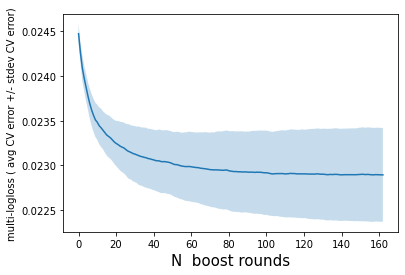

In [18]:
H = pd.DataFrame()

H['mean'] = hist['multi_logloss-mean']
H['std'] = hist['multi_logloss-stdv']
H['upper'] = H['mean'] + H['std']
H['lower'] = H['mean'] - H['std']
plt.xlabel('N  boost rounds', fontsize = 15)
plt.ylabel('multi-logloss ( avg CV error +/- stdev CV error)', fontsize = 10)
plt.plot(H['mean'])
plt.fill_between(H.index, H['lower'], H['upper'], alpha = 0.25)
plt.show()

#### Save CCX model

In [19]:
model_CCX.save_model(PATH_OBJECTS + "model_CCX_CG")

### model based on CLX control group  (cash)

#### Model training data

In [20]:
from sklearn.model_selection import  train_test_split

mask = data['CA_TYPE'].isin(['CLX']) & (data['CA_F_CASH_CARD_TG_CG'].isin([ 'CG']))

train , test  = train_test_split(data[mask] , test_size = 0.5, random_state = 42,\
                                stratify = data[mask][ [col_month, col_target,col_campaign] ])

train = train.reset_index(drop = True)
test =  test.reset_index(drop = True)
test_CLX = test.copy()

#[]
T = train
X = predictors
Y = col_target
w = col_weight
lgbm_train_data = lgb.Dataset(T[X], label = T[Y], weight = T[w], categorical_feature = cols_pred_cat, free_raw_data=False)

In [21]:
print(train[col_target].value_counts())
print(test[col_target].value_counts())

0    264297
1       613
2        50
Name: target, dtype: int64
0    264299
1       615
2        47
Name: target, dtype: int64


#### Tune  the following Ligtgbm Hyperparameters 
**['feature_fraction','num_leaves', 'bagging_fraction', 'bagging_freq', 'lambda_l1', 'lambda_l2', 
                  'min_child_samples']**
                                    
**This is a houristic approach based on experiences from Kaggle competition, tuning the HyperParameters sequentialy (one by one) in the order given above , while keeping other Hyperparameters at their default settings (including learning rate = 0.1).**

**It is considerably faster than the full-blown approach (on the product of individual HP spaces)**
**while attaining similar performance**

**It is implemented in the Opruna HP optimization backage v 2.10 (LightGBMTuner , LightGBMTunerCV).**

In [22]:
params = default_params.copy()

study_tuner = optuna.create_study(direction='minimize')

CLX_tuner = lgbm_integration.LightGBMTunerCV(params, 
                            lgbm_train_data, 
                            study=study_tuner,
                            nfold=_NFLOD,
                            stratified = _STRATIFIED,
                            shuffle=_SHUFFLE, 
                            verbose_eval=False,                            
                            time_budget=14400, # Time budget of 4 hours, we will not really need it <--#change this to lower value for implementation
                            callbacks=[])
s = time.time()
CLX_tuner.run()
e = time.time()
print('HP optimization took : ', e-s ,' seconds')

[I 2022-03-14 12:49:36,680] A new study created in memory with name: no-name-e581dd63-5015-4131-a850-47eb25b46e17
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
feature_fraction, val_score: 0.021608:  14%|######4                                      | 1/7 [00:18<01:53, 18.86s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
feature_fraction, val_score: 0.021608:  29%|############8                                | 2/7 [00:34<01:23, 16.72s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset

num_leaves, val_score: 0.021608:  35%|#################5                                | 7/20 [04:14<07:50, 36.22s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
num_leaves, val_score: 0.019957:  40%|####################                              | 8/20 [04:29<05:52, 29.36s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
num_leaves, val_score: 0.019957:  45%|######################5                           | 9/20 [05:09<06:01, 32.83s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
num_leaves, val_score: 0.019513:  50%|########################5                        | 10/20 [05:25<04:33, 27.

bagging, val_score: 0.017091:   0%|                                                             | 0/10 [00:00<?, ?it/s]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
bagging, val_score: 0.017091:  10%|#####3                                               | 1/10 [00:23<03:28, 23.16s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
bagging, val_score: 0.017091:  20%|##########6                                          | 2/10 [00:49<03:18, 24.76s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
bagging, val_score: 0.017091:  30%|###############9                                     | 3/10 [01:25<03:31, 30.

feature_fraction_stage2, val_score: 0.017076:  50%|###################                   | 3/6 [01:23<01:25, 28.39s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
feature_fraction_stage2, val_score: 0.017076:  67%|#########################3            | 4/6 [01:57<01:01, 30.58s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
feature_fraction_stage2, val_score: 0.017076:  83%|###############################6      | 5/6 [02:31<00:31, 31.78s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.017076:   0%|                                              | 0/20 [00:00<?,

regularization_factors, val_score: 0.017068:  50%|##################5                  | 10/20 [05:44<05:52, 35.21s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.017051:  55%|####################3                | 11/20 [06:31<05:49, 38.80s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.017051:  60%|######################2              | 12/20 [07:15<05:23, 40.45s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
regularization_factors, val_score: 0.017049:  65%|########################             | 13/20 [07:57<04:45, 40.

min_data_in_leaf, val_score: 0.017049:  60%|###########################                  | 3/5 [02:00<01:21, 40.88s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
min_data_in_leaf, val_score: 0.017049:  80%|####################################         | 4/5 [02:39<00:39, 39.95s/it]Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.
min_data_in_leaf, val_score: 0.017049: 100%|#############################################| 5/5 [03:17<00:00, 39.60s/it]

HP optimization took :  2076.6848204135895  seconds


**Get the model corresponding to the optimal HP**

In [23]:
print(CLX_tuner.best_params)
print(CLX_tuner.best_score)
model_CLX , hist  = LGBM_trained_booster_CV(CLX_tuner.best_params, lgbm_train_data)

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


{'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'early_stopping_rounds': 100, 'num_iterations': 10000, 'max_bin': 20, 'seed': 1234, 'verbose': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'lambda_l1': 6.644139018121482, 'lambda_l2': 0.1812142938244111, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.9271612717967527, 'bagging_freq': 4, 'min_child_samples': 20}
0.01704868713452786


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


**(Optional) show the learning curve for optimal model**

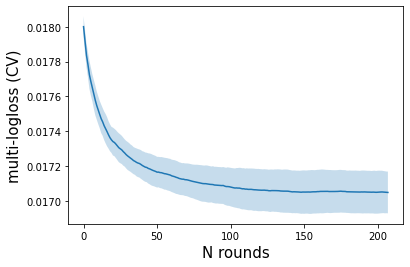

In [24]:
H = pd.DataFrame()

H['mean'] = hist['multi_logloss-mean']
H['std'] = hist['multi_logloss-stdv']
H['upper'] = H['mean'] + H['std']
H['lower'] = H['mean'] - H['std']
plt.xlabel('N rounds', fontsize = 15)
plt.ylabel('multi-logloss (CV)', fontsize = 15)
plt.plot(H['mean'])
plt.fill_between(H.index, H['lower'], H['upper'], alpha = 0.25)
plt.show()

#### Save CLX model

In [25]:
model_CLX.save_model(PATH_OBJECTS + "model_CLX_CG")

### Save test data

**Optional : use test data as the source data for the uplift anf cutoff script (PHASE 2)**

**If not, never use the same, or overlapping,  data for PHASE II and for model training ( this phase : PHASE I)**

In [26]:
df = pd.concat([test_CCX, test_CLX], axis = 0)
df = df.reset_index(drop = True)
df.to_csv(PATH_DATA + 'PHASE2.csv', encoding = 'utf-8')

## Performances on test set

### Load models

In [27]:
model_CCX = lgb.Booster(model_file= PATH_OBJECTS + "model_CCX_CG")
model_CLX = lgb.Booster(model_file= PATH_OBJECTS + "model_CLX_CG")

In [28]:
def binarize(x, label):
    if x == label:
        binary =1
    else:
        binary =0
    return binary


def ROC_calc(y, X, W, label, color, _linestyle='-', _linewidth = 2 ):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr, tpr, thresholds = metrics.roc_curve(y, X,sample_weight= W)
    #roc_auc = metrics.auc(fpr, tpr,reorder=True)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='%s (Gini = %0.5f)' % (label, 2*roc_auc-1), linestyle=_linestyle, linewidth = _linewidth , alpha=.6)
    print('%s, %0.5f, %0.6f' % (label,2*roc_auc-1, metrics.mean_squared_error(y, X, sample_weight= W)))

In [29]:
df_CCX = test_CCX.copy()
df_CCX_predprob = model_CCX.predict(df_CCX[predictors], num_iteration = model_CCX.best_iteration)

df_CLX = test_CLX.copy()
df_CLX_predprob = model_CLX.predict(df_CLX[predictors], num_iteration = model_CLX.best_iteration)

Cash_Card(CCX), 0.55581, 0.003324
Cash_Card(CLX), 0.49103, 0.002481


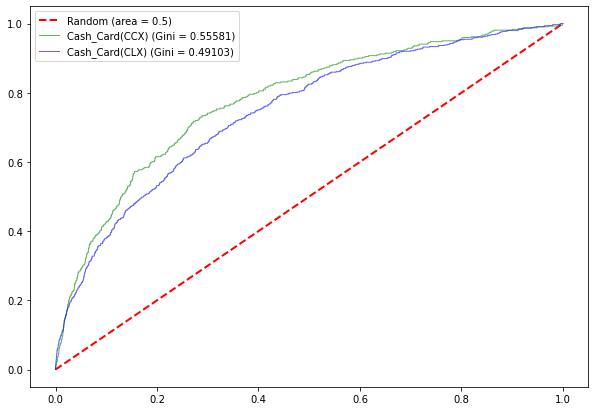

Cash(CCX), 0.42142, 0.001446
Cash(CLX), 0.48071, 0.002307


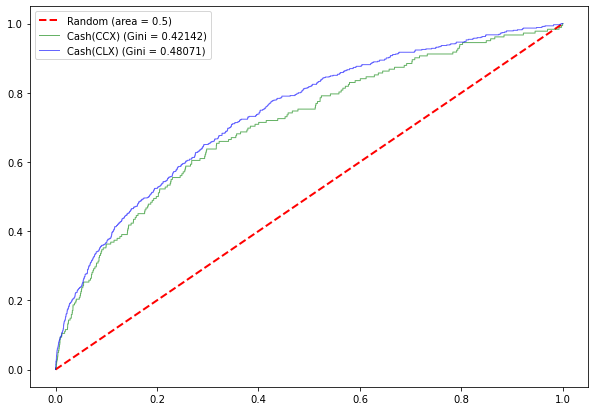

Card(CCX), 0.66286, 0.001892
Card(CLX), 0.67164, 0.000177


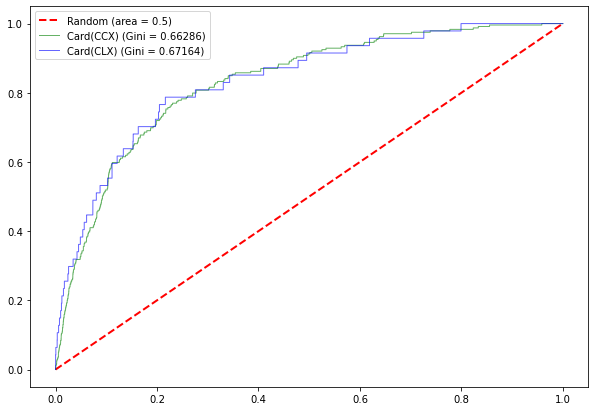

In [30]:
def label(response):
    if response == 'none': 
        c = 0
    if response == 'Cash':
        c = 1
    if response == 'Card':
        c = 2
    return c

#[]
plt.figure(figsize = (10,7))

df_CCX['binary'] = df_CCX[col_target].apply(lambda x: 1 if (x == 1) or (x == 2) else 0)
df_CLX['binary'] = df_CLX[col_target].apply(lambda x: 1 if (x == 1) or (x == 2) else 0)

plt.plot([0, 1], [0, 1], linestyle='--', color='r', linewidth = 2, label='Random (area = 0.5)')
ROC_calc(df_CCX['binary'], df_CCX_predprob[:,label('Cash')] + df_CCX_predprob[:,label('Card')]  , df_CCX[col_weight], 'Cash_Card(CCX)' , 'green', _linestyle='-', _linewidth = 1)
ROC_calc(df_CLX['binary'], df_CLX_predprob[:,label('Cash')] + df_CLX_predprob[:,label('Card')] , df_CLX[col_weight], 'Cash_Card(CLX)' , 'blue', _linestyle='-', _linewidth = 1)
plt.legend()

plt.savefig(PATH_RESULTS +'either.png')
plt.show()  


for response in ['Cash', 'Card']:
    
    plt.figure(figsize = (10,7)) 
    
    df_CCX['binary'] = df_CCX[col_target].apply(lambda x : binarize(x,label(response)))
    df_CLX['binary'] = df_CLX[col_target].apply(lambda x : binarize(x,label(response)))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', linewidth = 2, label='Random (area = 0.5)')
    ROC_calc(df_CCX['binary'], df_CCX_predprob[:,label(response)] , df_CCX[col_weight], response + '(CCX)' , 'green', _linestyle='-', _linewidth = 1)
    ROC_calc(df_CLX['binary'], df_CLX_predprob[:,label(response)] , df_CLX[col_weight], response + '(CLX)' , 'blue', _linestyle='-', _linewidth = 1)
    plt.legend()

    plt.savefig(PATH_RESULTS + response +'.png')
    plt.show()  
